# Example usage of `sgfixedincome_pkg` (Main Analysis Use Case)

This Jupyter Notebook vignette shows how some functions from the `sgfixedincome_pkg` can be used. This Vignette primarily focuses on functions found in `analysis.py` which most users would find useful. 

We expect functions found in the other scripts to be less commonly used by the average user. If interested in those other functions, please refer to the other vignettes or documentation for guidance.

## Fetch data
Let's import the package and fetch data on retail fixed income products using `create_combined_df()`:

In [1]:
import sgfixedincome_pkg as sfi

# Fetch bank, SSB, T-bill data with default inputs
combined_df, fetch_failures, warnings_list = sfi.create_combined_df()

# Display output
print(f"Fetch failures: {fetch_failures}")
print(f"Fetch warnings: {warnings_list}")
print(f"Dataframe shape: {combined_df.shape}")
combined_df.head(3)

Fetch failures: []
Fetch warnings: []
Dataframe shape: (399, 7)


,Tenure,Rate,Deposit lower bound,Deposit upper bound,Required multiples,Product provider,Product
0,1.0,0.30,1000.0,9999.0,None,DBS,Fixed Deposit
1,1.0,0.30,10000.0,19999.0,None,DBS,Fixed Deposit
2,1.0,0.05,20000.0,49999.0,None,DBS,Fixed Deposit


We have empty lists for fetch failures and warnings. This suggests that we were able to successfully fetch data from all the default banks (DBS, OCBC, UOB) as well as SSB and T-bill data. We also do not have any warnings to note.

To know which products we have successfully fetched into our dataset, we can use `products()`:

In [2]:
sfi.products(combined_df)

['DBS - Fixed Deposit',
 'UOB - Fixed Deposit',
 'OCBC - Fixed Deposit',
 'MAS - SSB GX25010E',
 'MAS - T-bill BS24124Z']

## Analyze data

### Find best returns available

Let's say that you are a retail investor who has \$9,900 sitting idly and you want to find the best rates you can earn on it. You are open to locking up the money for 5 to 7 months. For convenience, you intend to invest the full amount into a single product.

You can use `best_returns()` to find the highest total dollar return (excluding fees) achievable for each tenure and the product that enables this return:

In [3]:
# Find best returns for S$9,900 locked for 5 to 7 months
sfi.best_returns(combined_df, 9900, 5, 7)

,Tenure,Rate,Deposit lower bound,Deposit upper bound,Required multiples,Product provider,Product,Invested amount,Total Dollar Return
0,5.0,2.75,500.0,200000.0,500,MAS,SSB GX25010E,9500,107.99
1,6.0,3.00,1000.0,99999999.0,1000,MAS,T-bill BS24124Z,9000,134.00
2,7.0,2.75,500.0,200000.0,500,MAS,SSB GX25010E,9500,151.53


Note that the `Invested Amount` may differ from the \$9,900 investment amount we input into the function, as some products like SSBs and T-bills only accept investment in specific multiples. The function allocates the maximum amount of investment possible, subject to the required multiples.

This result can be used to inform your investment decisions.

### Filter data before finding best returns

Now, say that you are a pre-existing customer of DBS bank, and you do not wish to consider fixed deposit products from other banks. For some reason, you also do not want to consider SSBs. Then, you can filter the initial dataset  with `filter_df()` first before passing it into `best_returns()`:

In [4]:
# Ignore SSBs and only consider DBS for banks when finding best returns
filtered_df = sfi.filter_df(
    combined_df, consider_ssbs=False, include_providers=["DBS", "MAS"]
)
sfi.best_returns(filtered_df, 9900, 5, 7)

,Tenure,Rate,Deposit lower bound,Deposit upper bound,Required multiples,Product provider,Product,Invested amount,Total Dollar Return
0,5.0,1.75,1000.0,9999.0,None,DBS,Fixed Deposit,9900,71.82
1,6.0,3.00,1000.0,99999999.0,1000,MAS,T-bill BS24124Z,9000,134.00
2,7.0,2.30,1000.0,9999.0,None,DBS,Fixed Deposit,9900,132.20


Notice that the result above does not include SSB and banks other than DBS. However, this restriction may lead to the best dollar return for each tenure being lower compared to our initial result with an unfiltered dataset, since we now ignore some possibly better products. 

View the documentation for the full list of arguments the `filter_df()` function takes, which provides great flexibility for which products to include or exclude in analysis.

### Find best rates available

Instead of finding the best returns available for each tenure, you may simply be interested in finding the best rates available. Though this often gives a similar output as `best_returns()`, the output sometimes differ.

For example, product ‘A’ with a slightly higher rate but which has required multiples of investment may produce lower total dollar return compared to product ‘B’ with a lower rate but no required multiples, as the full amount of cash cannot be invested in product ‘A’ but can be fully invested into product ‘B’.

You can find the best rates for each tenure with the `best_rates()` function:

In [5]:
sfi.best_rates(combined_df, 9900, 5, 7)

,Tenure,Rate,Deposit lower bound,Deposit upper bound,Required multiples,Product provider,Product
0,5.0,2.75,500.0,200000.0,500,MAS,SSB GX25010E
1,6.0,3.00,1000.0,99999999.0,1000,MAS,T-bill BS24124Z
2,7.0,2.75,500.0,200000.0,500,MAS,SSB GX25010E


### Find weakly better investment allocations

Our analysis thus far assumes that you can only invest your full sum to a single product. However, to improve returns, it is sometimes optimal to allocate your investment amount across several products. 

You can use `better_allocation()` to do this for you. Importantly, while this strategy often produces a weakly better return and effective rate than pure single-product investment strategies, it does not necessarily produce the best allocation. In some specific scenarios, it may even be less optimal than pure strategies. Refer to documentation for details.

Below, consider an investor with a 12-month tenure horizon and \$250,000:

In [6]:
allocation_df = sfi.better_allocation(combined_df, 250000, 12)
print("A better allocation strategy:")
allocation_df

A better allocation strategy:


,Product provider,Product,Allocated amount,Rate (% p.a.),Expected return ($)
0,MAS,SSB GX25010E,200000.0,2.73,5460.00
1,DBS,Fixed Deposit,19999.0,2.45,489.98
2,UOB,Fixed Deposit,30001.0,1.50,450.01
3,Total,All Products,250000.0,2.56,6399.99


## Visualize data

To better understand the data, we provide some functions to visualize it.

### Plot all products offerings given investment amount

With our investment amount of \$9,900, let's view the rates offered across all products and tenures in our dataset. We can do this using `plot_rates_vs_tenure()`:

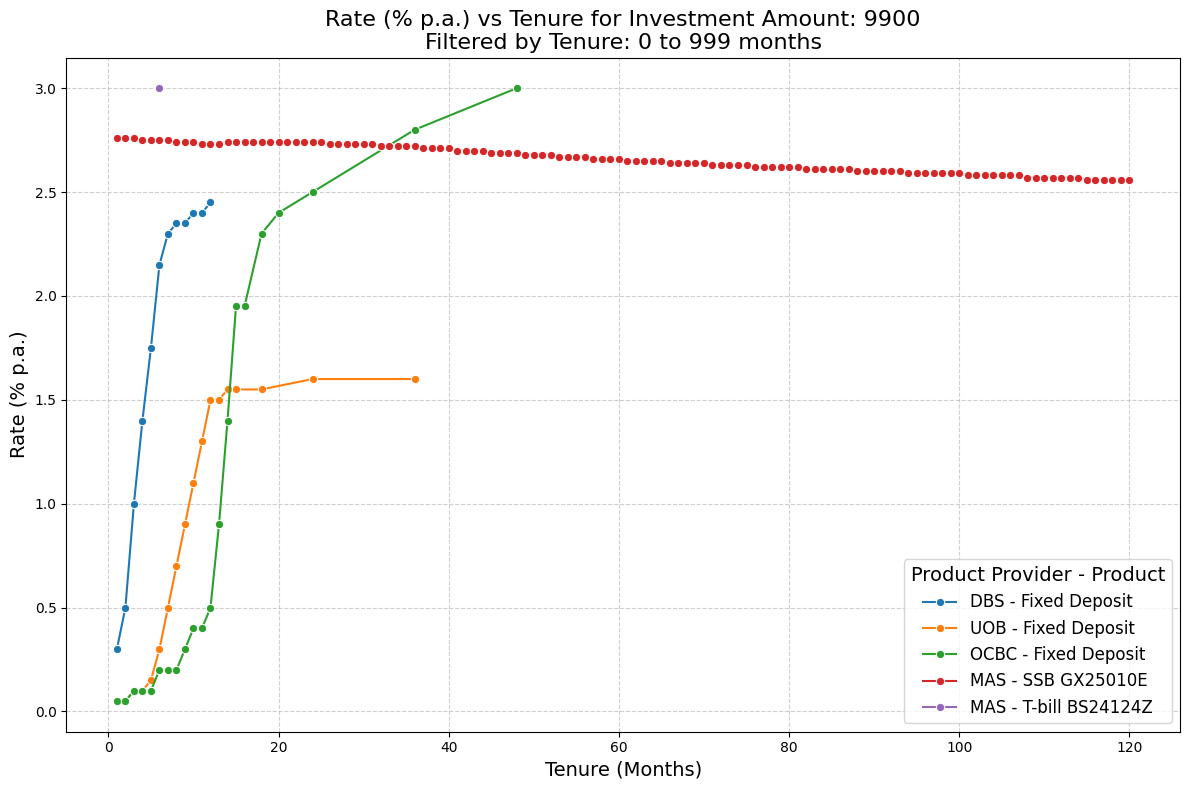

In [7]:
sfi.plot_rates_vs_tenure(combined_df, 9900)

Optionally, we can control the range of tenures displayed in the plot:

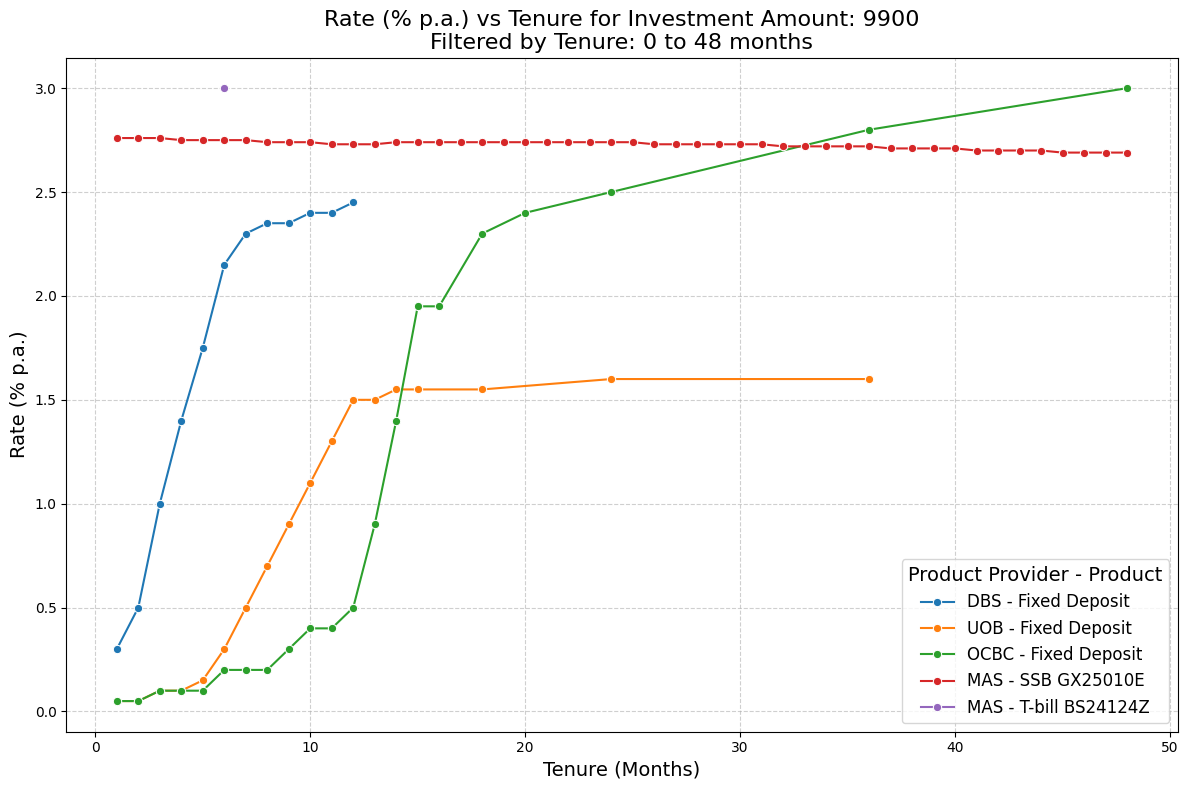

In [8]:
sfi.plot_rates_vs_tenure(combined_df, 9900, min_tenure=0, max_tenure=48)

For bank fixed deposit products, we generally observe that rates offered (% p.a.) rises with longer tenures. For the SSB, the rate decreases gradually with longer tenures. This may initially seem counter-intuitive as the SSBs issued by MAS are structured to have increasing coupon rates over time. However, the pace of the coupon rate increase is often insufficient to reverse the fall in annualized compounded rates (in % p.a.) over time. Intuitively, the compounding effect means a small annualized rate can produce large percentage returns over time, and this effect is stronger with longer tenures.

### Plot best rates

Next, let's visualize the best rates for each tenure across available products, given that we intend to invest \$9,900. We can use `plot_best_rates()` to do this:

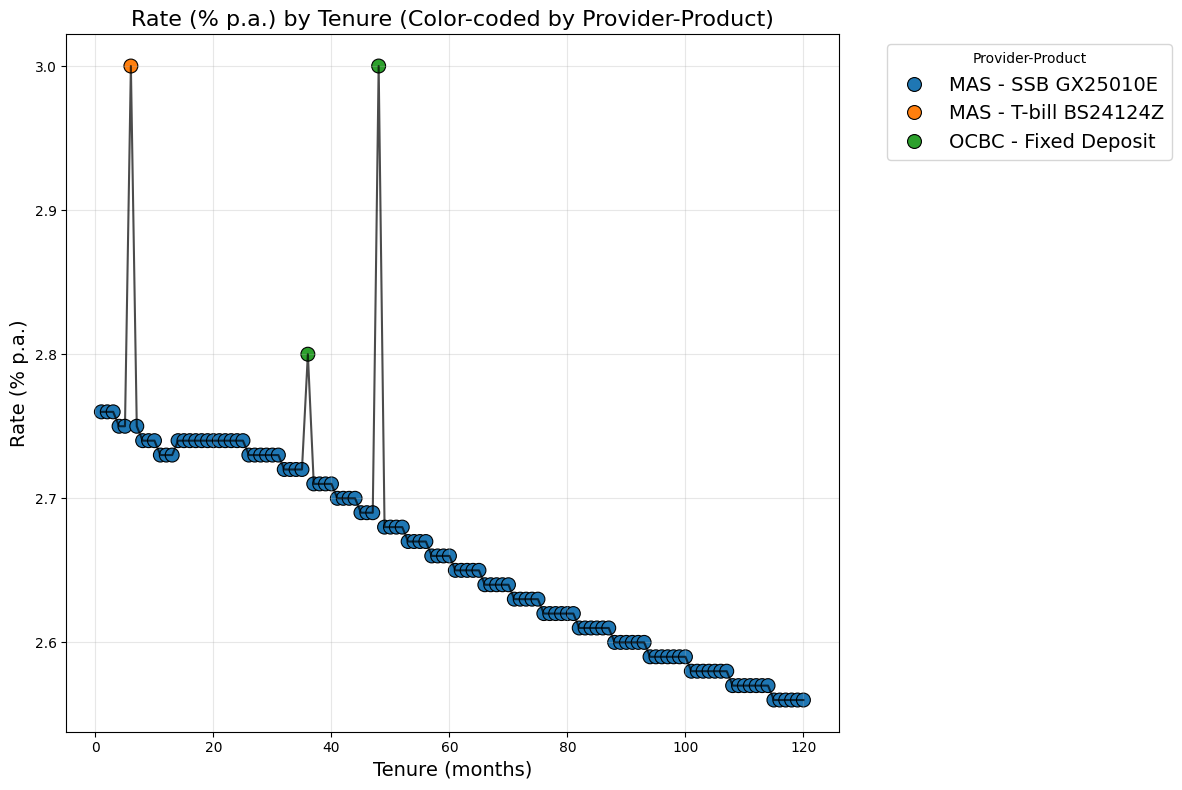

In [9]:
sfi.plot_best_rates(combined_df, 9900)

We may find such a plot useful as it helps us quickly identify specific tenures where higher rates are available which could be interesting investments.

Like before, we may wish to plot the best rates but only for a subset of products we are considering to invest in. We can simply do this by passing in the filtered dataframe into the `plot_best_rates()` function:

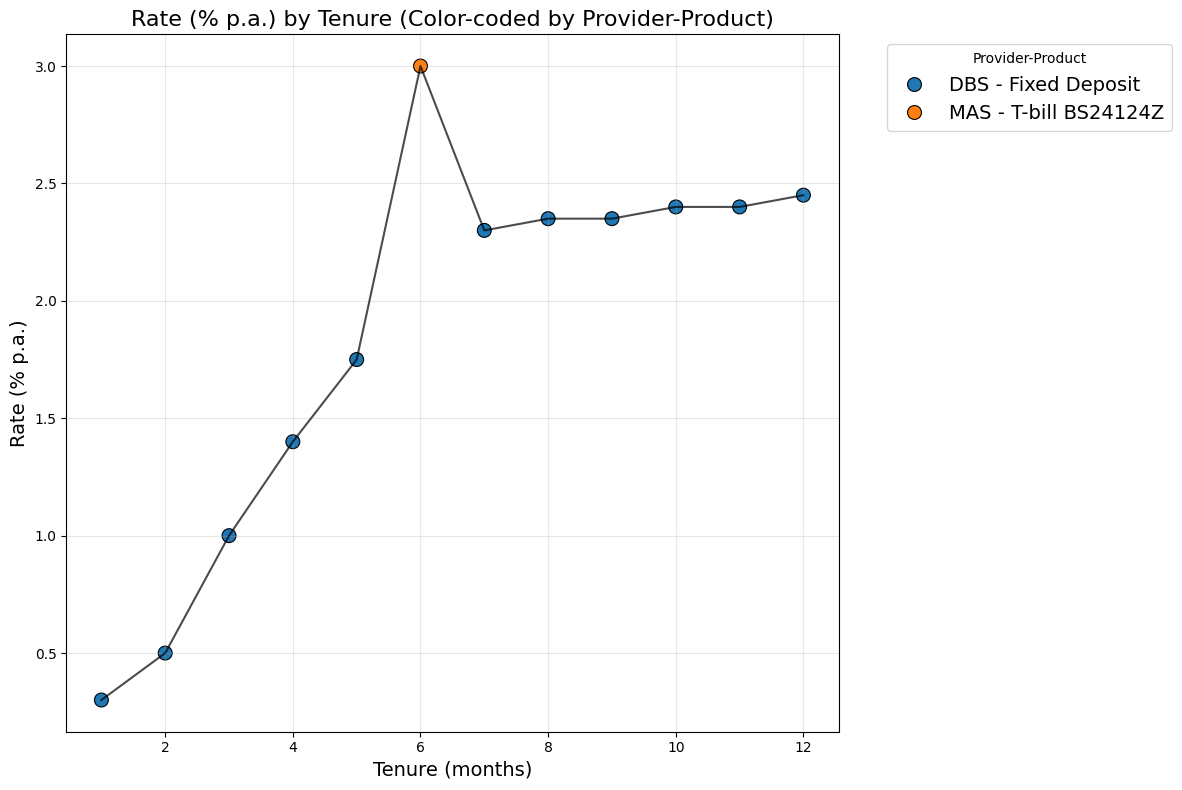

In [10]:
sfi.plot_best_rates(filtered_df, 9900)

Recall that our filtered dataset does not include SSBs. As are no other products with longer tenures reaching 120 months, the range of tenures plotted here is lower.

### Plot the better allocation strategy

We can also plot the effective rates from the investment allocation produced in by the `better_allocation()` function for a \$250,000 investment amount:

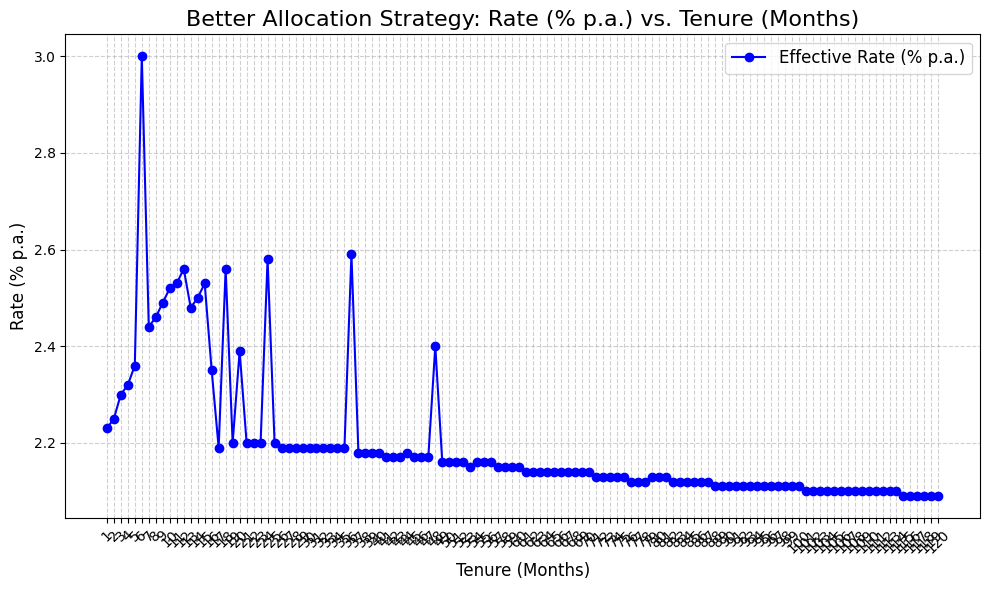

In [11]:
sfi.plot_better_allocation_strategy(combined_df, 250000)

You can overlay this plot with the plot of rates for pure strategies. This overlay enables us to better identify the tenures in which our 'better allocation' strategy produces a better effective rate compared to pure strategies for a given investment amount (in this case, \$250,000):

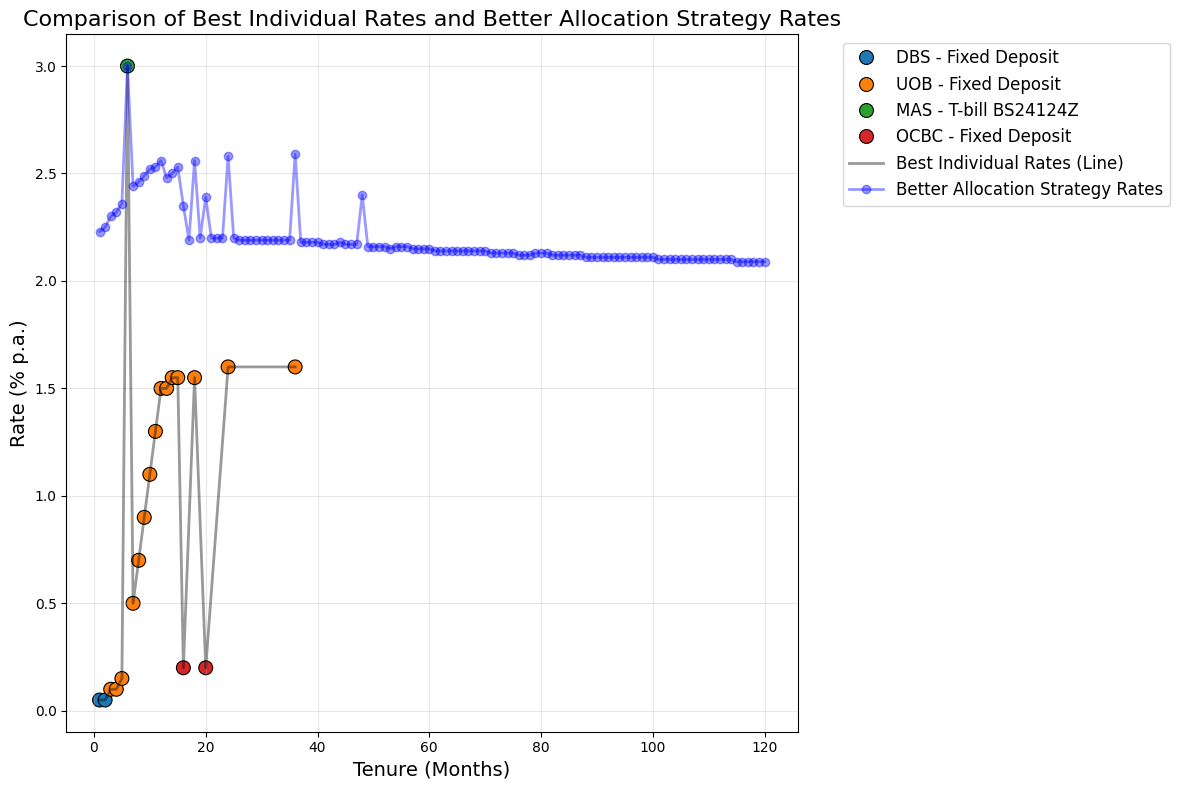

In [12]:
sfi.plot_pure_and_better_allocation_strategy_rates(combined_df, 250000)

Note that the `better_allocation()` strategy is generally more useful with large investment amounts where investors would benefit more from splitting investments across products. For moderate and smaller investment amounts, the single-product strategy and best allocation strategy produces similar effective rates for most tenures. 

Consider the case of a \$25,000 investment sum below:

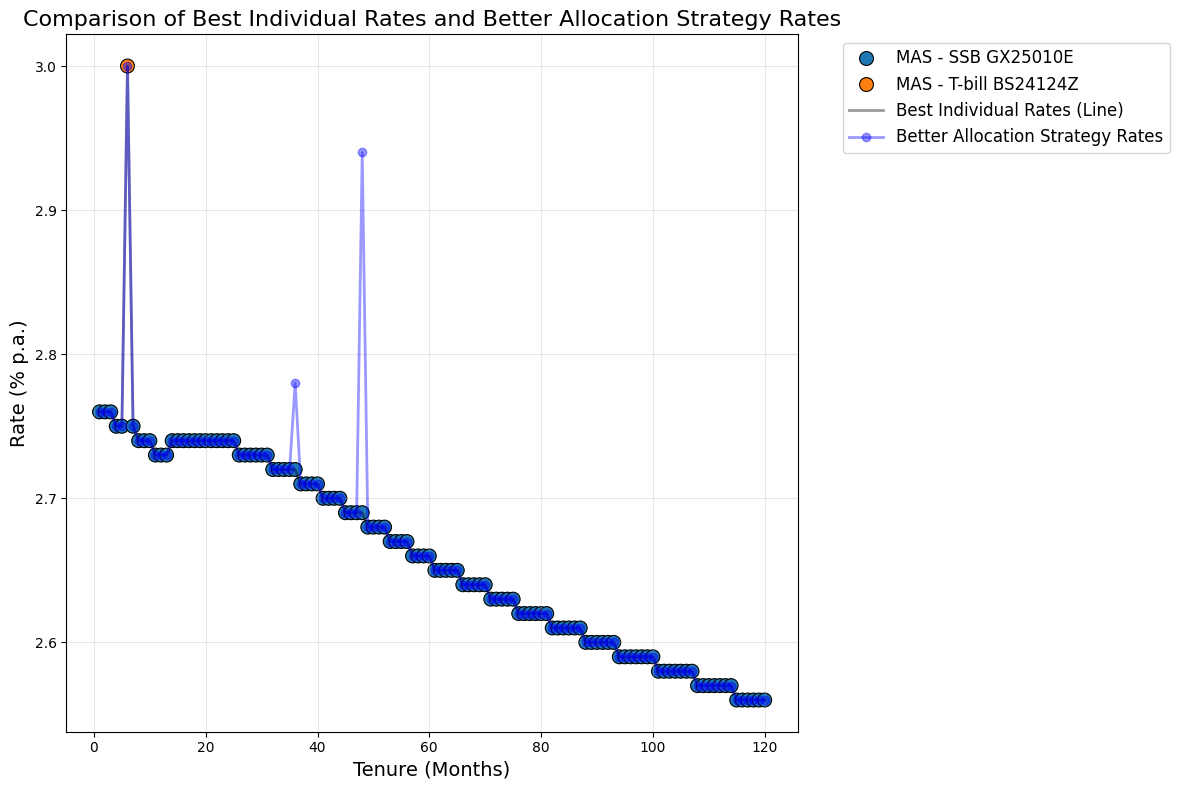

In [13]:
sfi.plot_pure_and_better_allocation_strategy_rates(combined_df, 25000)

### Plot single bank offerings

Thus far, our plots only displayed rates offered for specific investment amounts which we input. It could also be interesting to visualize how offered rates vary across investment amounts. This is useful primarily for bank fixed deposit products. This can be done with `plot_bank_offerings_with_fuzz()`:

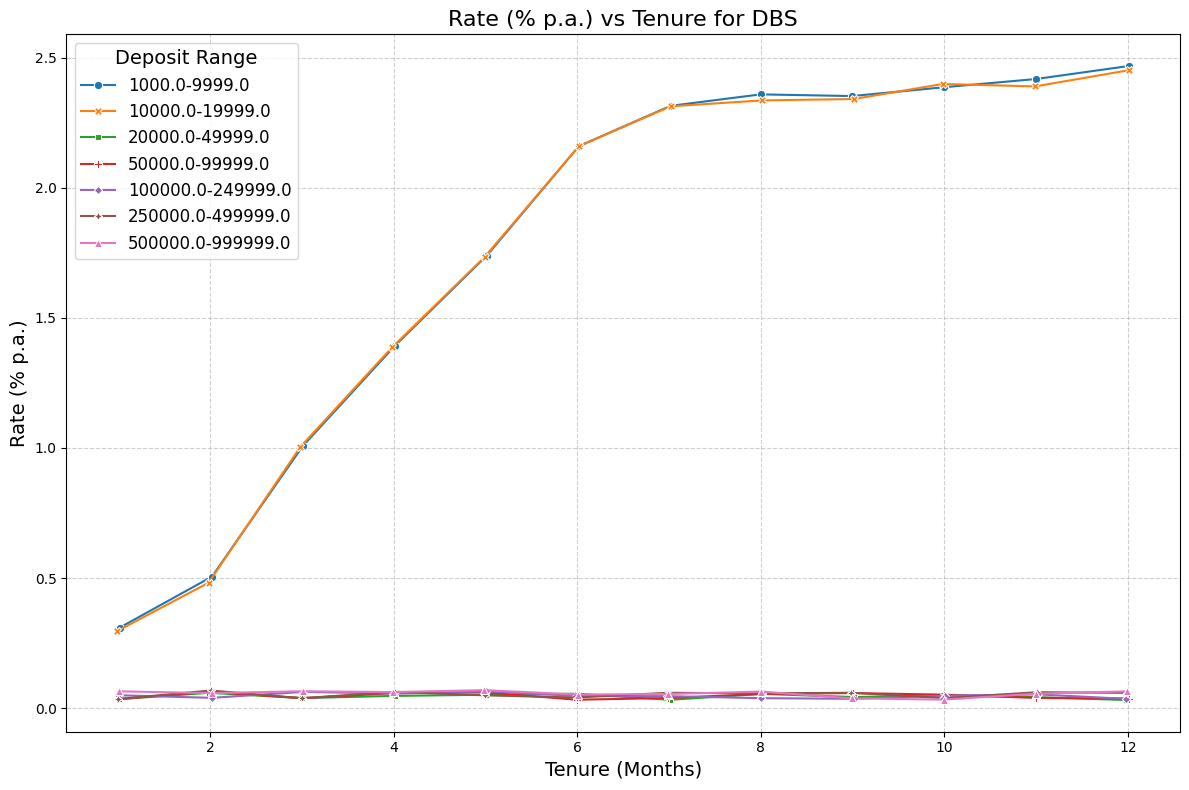

In [14]:
# Plot DBS fixed deposit offerings
sfi.plot_bank_offerings_with_fuzz(combined_df, "DBS")

We find that DBS bank provides higher rates for deposits up to \$19,999, and very low rates for higher deposit values. Seeing this, investors may choose to not invest beyond that threshold amount in DBS fixed deposit products and consider other providers or products for additional idle cash.

Note that some small amount of fuzz is automatically added to the data points so they can be viewed better and to combat the issue of points being directly on top of each other. This is a common occurence as banks often offer the same rate for a given tenure across a couple of deposit ranges.